# IPL Score Prediction - Linear Regression Model

This notebook implements a basic linear regression model to predict IPL cricket scores based on match features.

In [10]:
# %pip install pandas numpy torch matplotlib
# %pip install scikit-learn

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"CUDA Device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Memory Allocated: {torch.cuda.memory_allocated(0)/1024**2:.2f} MB")

Using device: cuda
CUDA Device: NVIDIA GeForce MX350
CUDA Memory Allocated: 0.00 MB


## Data Loading and Preprocessing

In [12]:
# Load the datasets
try:
    # First, try to load the preprocessed dataset if it exists
    df = pd.read_csv('cleaned_data/weighted_run_rate_dataset.csv')
    print("Loaded preprocessed dataset.")
except FileNotFoundError:
    print("Preprocessed dataset not found. Loading and preprocessing raw data...")
    # Load raw data
    deliveries = pd.read_csv('data/ball_to_ball/deliveries.csv')
    matches = pd.read_csv('data/match_id/matches.csv')
    
    # Merge datasets
    df = pd.merge(deliveries, matches, left_on='match_id', right_on='id')
    
    # Perform basic preprocessing
    # Group by match_id, inning, over to get per-over statistics
    over_stats = df.groupby(['match_id', 'inning', 'over']).agg(
        total_runs=('total_runs', 'sum'),
        is_wicket=('is_wicket', 'sum'),
        batting_team=('batting_team', 'first'),
        bowling_team=('bowling_team', 'first'),
        season=('season', 'first')
    ).reset_index()
    
    # Calculate cumulative stats
    result = []
    for (match_id, inning), group in over_stats.groupby(['match_id', 'inning']):
        group = group.sort_values('over')
        cum_runs = 0
        cum_wickets = 0
        
        for idx, row in group.iterrows():
            cum_runs += row['total_runs']
            cum_wickets += row['is_wicket']
            
            # Calculate run rate
            run_rate = cum_runs / row['over'] if row['over'] > 0 else 0
            
            # Calculate target and required run rate for 2nd innings
            target = 0
            req_runrate = 0
            target_left = 0
            
            if inning == 2:
                # Find target from 1st innings
                first_inning = over_stats[(over_stats['match_id'] == match_id) & 
                                          (over_stats['inning'] == 1)]
                if not first_inning.empty:
                    target = first_inning['total_runs'].sum() + 1
                    target_left = target - cum_runs
                    remaining_overs = 20 - row['over']
                    req_runrate = target_left / remaining_overs if remaining_overs > 0 else 0
            
            # Create a record for the current over
            curr_run_rate = row['total_runs']  # Runs in current over
            
            result.append({
                'match_id': match_id,
                'inning': inning,
                'over': row['over'],
                'batting_team': row['batting_team'],
                'bowling_team': row['bowling_team'],
                'season': row['season'],
                'total_runs_in_over': row['total_runs'],
                'is_wicket': row['is_wicket'],
                'cum_runs': cum_runs,
                'cum_wickets': cum_wickets,
                'run_rate': run_rate,
                'curr_run_rate': curr_run_rate,
                'target': target,
                'target_left': target_left,
                'req_runrate': req_runrate
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(result)
    
    # Calculate weighted run rate
    alpha = 0.7  # Weight for current run rate vs. historical
    
    # Initialize weighted run rate column
    df['weighted_run_rate'] = 0.0
    
    # Process each match and inning separately
    for (match_id, inning), group in df.groupby(['match_id', 'inning']):
        # Sort by over to ensure correct sequence
        group = group.sort_values('over')
        
        # Initialize weighted run rate with the first over's run rate
        weighted_rr = group['curr_run_rate'].iloc[0]
        
        # Process each row and update the weighted run rate
        for idx, row in group.iterrows():
            if row['over'] == 1:  # First over - just use its run rate
                df.loc[idx, 'weighted_run_rate'] = row['curr_run_rate']
            else:
                # Apply the formula: α(RR_current) + (1-α)(RR_previous_weighted)
                weighted_rr = alpha * row['curr_run_rate'] + (1-alpha) * weighted_rr
                df.loc[idx, 'weighted_run_rate'] = weighted_rr
    
    # Save the preprocessed dataset
    df.to_csv('cleaned_data/weighted_run_rate_dataset.csv', index=False)
    print("Preprocessing completed. Dataset saved to 'cleaned_data/weighted_run_rate_dataset.csv'")

# Display dataframe info
print("\nDataset shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nSample data:")
df.head()

Loaded preprocessed dataset.

Dataset shape: (42213, 15)

Columns: ['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'season', 'who_is_batting_first', 'total_runs', 'is_wicket', 'run_rate', 'target_runs', 'target_left', 'req_runrate', 'curr_run_rate', 'weighted_run_rate']

Sample data:


,match_id,inning,batting_team,bowling_team,over,season,who_is_batting_first,total_runs,is_wicket,run_rate,target_runs,target_left,req_runrate,curr_run_rate,weighted_run_rate
0,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,1,2007/08,Kolkata Knight Riders,3,0,3.0,0,0,0.0,3,3.00
1,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,2,2007/08,Kolkata Knight Riders,18,0,10.5,0,0,0.0,18,13.50
2,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,3,2007/08,Kolkata Knight Riders,6,0,9.0,0,0,0.0,6,8.25
3,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,4,2007/08,Kolkata Knight Riders,23,0,12.5,0,0,0.0,23,18.58
4,335982,1,Kolkata Knight Riders,Royal Challengers Bengaluru,5,2007/08,Kolkata Knight Riders,10,0,12.0,0,0,0.0,10,12.57


## Feature Engineering

In [13]:
# Encode categorical features
df['season'] = df['season'].astype(str)
df['season_year'] = df['season'].apply(lambda x: int(x.split('/')[0]) if '/' in x else int(x))
max_year = 2024  # Assuming current year as the reference point

# Encode teams using LabelEncoder
team_encoder = LabelEncoder()
df['batting_team_encoded'] = team_encoder.fit_transform(df['batting_team'])
df['bowling_team_encoded'] = team_encoder.fit_transform(df['bowling_team'])

print("Team mapping:")
for i, team in enumerate(team_encoder.classes_):
    print(f"{i}: {team}")

# Calculate cumulative wickets for each match and inning
df['cum_wickets'] = df.groupby(['match_id', 'inning'])['is_wicket'].cumsum()

# Create feature for next over runs (target variable)
df['next_over_runs'] = df.groupby(['match_id', 'inning'])['total_runs'].shift(-1)

# Drop rows where next_over_runs is NaN (last over of each innings)
df = df.dropna(subset=['next_over_runs']).reset_index(drop=True)

# Define features for linear regression
features = [
    'over',
    'batting_team_encoded', 
    'bowling_team_encoded',
    'cum_wickets',
    'run_rate',
    'curr_run_rate',
    'weighted_run_rate'
]

# Add features specific to second innings
df['is_second_inning'] = (df['inning'] == 2).astype(int)
features.append('is_second_inning')

# For second innings, add target-related features
second_inning_mask = df['inning'] == 2
df.loc[~second_inning_mask, ['target_left', 'req_runrate']] = 0
features.extend(['target_left', 'req_runrate'])

# Scale numerical features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df[features])

print("\nFeatures for model:")
print(features)

Team mapping:
0: Chennai Super Kings
1: Delhi Capitals
2: Gujarat Lions
3: Gujarat Titans
4: Kochi Tuskers Kerala
5: Kolkata Knight Riders
6: Lucknow Super Giants
7: Mumbai Indians
8: Pune Warriors
9: Punjab Kings
10: Rajasthan Royals
11: Rising Pune Supergiant
12: Royal Challengers Bengaluru
13: Sunrisers Hyderabad

Features for model:
['over', 'batting_team_encoded', 'bowling_team_encoded', 'cum_wickets', 'run_rate', 'curr_run_rate', 'weighted_run_rate', 'is_second_inning', 'target_left', 'req_runrate']


## Train-Test Split

In [14]:
# Split by match_id to prevent data leakage
match_ids = df['match_id'].unique()
train_match_ids, test_match_ids = train_test_split(match_ids, test_size=0.2, random_state=42)

# Create train and test sets
train_df = df[df['match_id'].isin(train_match_ids)].reset_index(drop=True)
test_df = df[df['match_id'].isin(test_match_ids)].reset_index(drop=True)

# Create scaled versions
train_df_scaled = df_scaled[df_scaled['match_id'].isin(train_match_ids)].reset_index(drop=True)
test_df_scaled = df_scaled[df_scaled['match_id'].isin(test_match_ids)].reset_index(drop=True)

print(f"Training set: {train_df.shape[0]} rows")
print(f"Testing set: {test_df.shape[0]} rows")

Training set: 32023 rows
Testing set: 7973 rows


## Linear Regression Model

In [15]:
# Extract features and target for both original and scaled datasets
X_train = train_df_scaled[features]
y_train = train_df['next_over_runs']

X_test = test_df_scaled[features]
y_test = test_df['next_over_runs']

# Train linear regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

# Calculate metrics
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Linear Regression Model Performance:")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")

Linear Regression Model Performance:
Train MAE: 3.5620, Test MAE: 3.5391
Train RMSE: 4.5021, Test RMSE: 4.4529
Train R²: 0.0690, Test R²: 0.0713


## Feature Importance

Feature Importance:
                Feature  Coefficient  Abs_Coefficient
0                  over     1.510409         1.510409
1      is_second_inning    -1.204469         1.204469
2           cum_wickets    -1.027707         1.027707
3     weighted_run_rate     0.996673         0.996673
4           target_left     0.838671         0.838671
5         curr_run_rate    -0.551005         0.551005
6           req_runrate     0.543768         0.543768
7  batting_team_encoded    -0.062951         0.062951
8              run_rate     0.054707         0.054707
9  bowling_team_encoded    -0.005927         0.005927


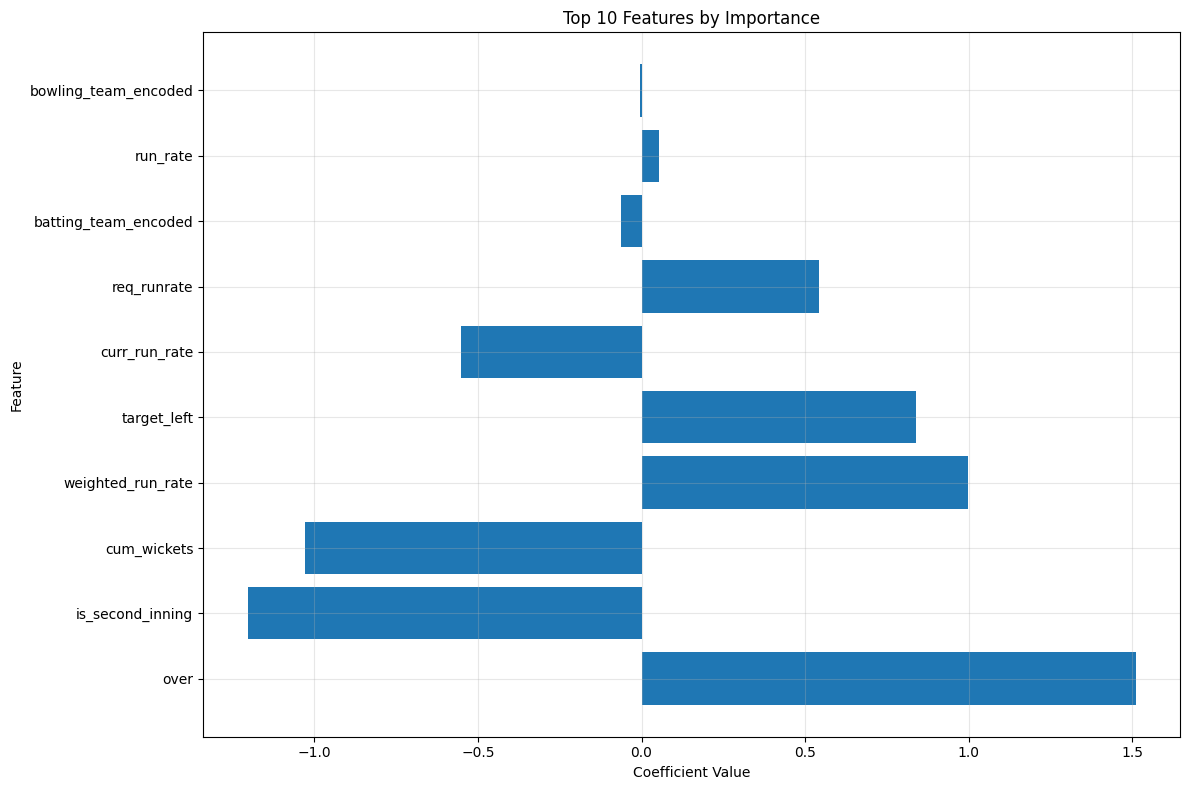

In [16]:
# Analyze feature importance
coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': lr_model.coef_
})

# Sort by absolute coefficient value
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False).reset_index(drop=True)

print("Feature Importance:")
print(coefficients)

# Plot feature importance
plt.figure(figsize=(12, 8))
plt.barh(coefficients['Feature'][:10], coefficients['Coefficient'][:10])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Features by Importance')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Prediction Analysis

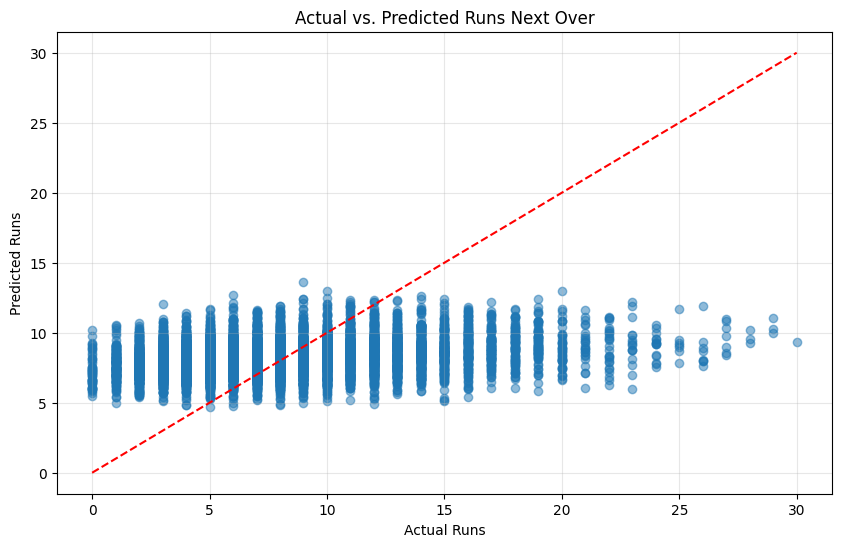

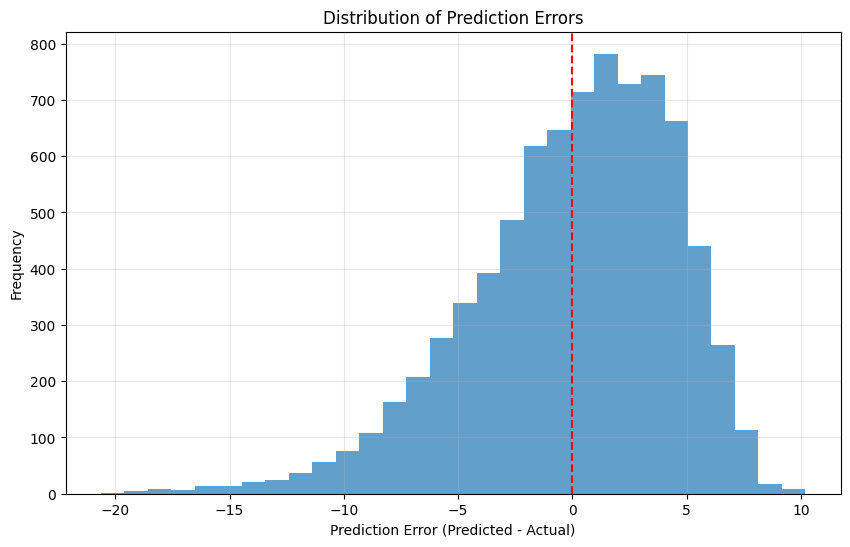

In [17]:
# Create a DataFrame with actual and predicted values
results_df = test_df.copy()
results_df['predicted_runs'] = y_test_pred
results_df['error'] = results_df['predicted_runs'] - results_df['next_over_runs']

# Plot actual vs predicted runs
plt.figure(figsize=(10, 6))
plt.scatter(results_df['next_over_runs'], results_df['predicted_runs'], alpha=0.5)
plt.plot([0, 30], [0, 30], '--', color='red')  # Diagonal line for perfect predictions
plt.xlabel('Actual Runs')
plt.ylabel('Predicted Runs')
plt.title('Actual vs. Predicted Runs Next Over')
plt.grid(True, alpha=0.3)
plt.show()

# Plot error distribution
plt.figure(figsize=(10, 6))
plt.hist(results_df['error'], bins=30, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)
plt.show()

## Innings Analysis

In [18]:
# Separate performance by innings
first_innings = results_df[results_df['inning'] == 1]
second_innings = results_df[results_df['inning'] == 2]

# Calculate metrics for each innings
first_mae = mean_absolute_error(first_innings['next_over_runs'], first_innings['predicted_runs'])
second_mae = mean_absolute_error(second_innings['next_over_runs'], second_innings['predicted_runs'])

first_rmse = np.sqrt(mean_squared_error(first_innings['next_over_runs'], first_innings['predicted_runs']))
second_rmse = np.sqrt(mean_squared_error(second_innings['next_over_runs'], second_innings['predicted_runs']))

first_r2 = r2_score(first_innings['next_over_runs'], first_innings['predicted_runs'])
second_r2 = r2_score(second_innings['next_over_runs'], second_innings['predicted_runs'])

print("Performance by Innings:")
print(f"First Innings - MAE: {first_mae:.4f}, RMSE: {first_rmse:.4f}, R²: {first_r2:.4f}")
print(f"Second Innings - MAE: {second_mae:.4f}, RMSE: {second_rmse:.4f}, R²: {second_r2:.4f}")

Performance by Innings:
First Innings - MAE: 3.5017, RMSE: 4.4071, R²: 0.0906
Second Innings - MAE: 3.5790, RMSE: 4.5013, R²: 0.0506


## Over-by-Over Prediction Accuracy

/tmp/ipykernel_81794/742666868.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  over_accuracy = results_df.groupby('over').apply(


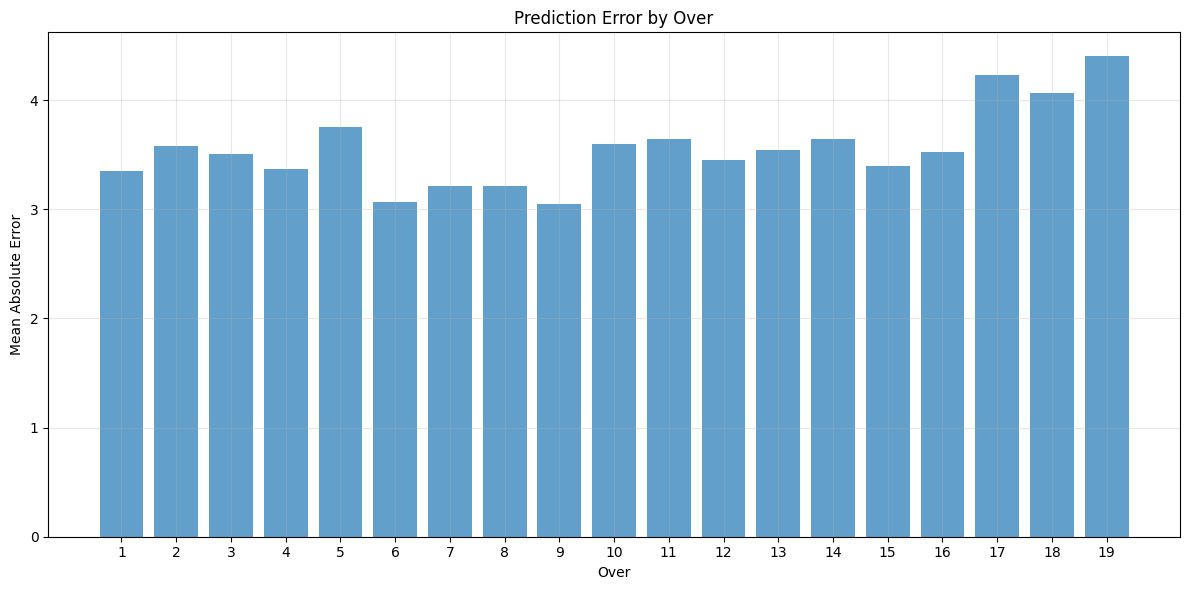

In [19]:
# Analyze prediction accuracy by over
over_accuracy = results_df.groupby('over').apply(
    lambda x: pd.Series({
        'mae': mean_absolute_error(x['next_over_runs'], x['predicted_runs']),
        'rmse': np.sqrt(mean_squared_error(x['next_over_runs'], x['predicted_runs'])),
        'count': len(x)
    })
).reset_index()

# Plot MAE by over
plt.figure(figsize=(12, 6))
plt.bar(over_accuracy['over'], over_accuracy['mae'], alpha=0.7)
plt.xlabel('Over')
plt.ylabel('Mean Absolute Error')
plt.title('Prediction Error by Over')
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 20))
plt.tight_layout()
plt.show()

## Prediction Function for New Matches

In [20]:
def predict_next_over_runs(model, scaler, encoder, batting_team, bowling_team, current_over, 
                           total_runs, total_wickets, target=0):
    """Predict runs for the next over based on current match state."""
    try:
        # Encode teams
        batting_team_encoded = encoder.transform([batting_team])[0]
        bowling_team_encoded = encoder.transform([bowling_team])[0]
        
        # Calculate derived features
        run_rate = total_runs / current_over if current_over > 0 else 0
        current_run_rate = total_runs / current_over if current_over > 0 else 0  # Simplified for demo
        weighted_run_rate = current_run_rate  # Simplified for demo
        
        # Determine innings and target-related features
        is_second_inning = 1 if target > 0 else 0
        target_left = max(0, target - total_runs) if target > 0 else 0
        remaining_overs = 20 - current_over
        req_runrate = target_left / remaining_overs if remaining_overs > 0 and target > 0 else 0
        
        # Create features array
        features_array = np.array([
            current_over + 1,  # next over
            batting_team_encoded,
            bowling_team_encoded,
            total_wickets,  # cum_wickets
            run_rate,
            current_run_rate,
            weighted_run_rate,
            is_second_inning,
            target_left,
            req_runrate
        ]).reshape(1, -1)
        
        # Scale features
        features_scaled = scaler.transform(features_array)
        
        # Make prediction
        prediction = model.predict(features_scaled)[0]
        return max(0, prediction)  # Ensure prediction is non-negative
    
    except Exception as e:
        print(f"Error in prediction: {e}")
        return None

In [21]:
# Example usage
print("\nExample Prediction:")
try:
    # Get list of teams for user selection
    teams = team_encoder.classes_
    print("Available teams:")
    for i, team in enumerate(teams):
        print(f"{i}: {team}")
    
    # Example prediction
    sample_batting_team = teams[0]  # Pick first team as an example
    sample_bowling_team = teams[1]  # Pick second team as an example
    
    # First innings prediction example
    first_innings_runs = predict_next_over_runs(
        model=lr_model,
        scaler=scaler,
        encoder=team_encoder,
        batting_team=sample_batting_team,
        bowling_team=sample_bowling_team,
        current_over=10,  # After 10 overs
        total_runs=80,
        total_wickets=2
    )
    
    print(f"\nFirst Innings Prediction:")
    print(f"Match situation: {sample_batting_team} vs {sample_bowling_team}, 10 overs completed")
    print(f"Current score: 80/2")
    print(f"Predicted runs in the next over: {first_innings_runs:.2f}")
    
    # Second innings prediction example
    second_innings_runs = predict_next_over_runs(
        model=lr_model,
        scaler=scaler,
        encoder=team_encoder,
        batting_team=sample_batting_team,
        bowling_team=sample_bowling_team,
        current_over=15,  # After 15 overs
        total_runs=120,
        total_wickets=5,
        target=160  # Chasing 160
    )
    
    print(f"\nSecond Innings Prediction:")
    print(f"Match situation: {sample_batting_team} vs {sample_bowling_team}, 15 overs completed")
    print(f"Current score: 120/5, Target: 160")
    print(f"Required: {160-120} runs from {20-15} overs")
    print(f"Predicted runs in the next over: {second_innings_runs:.2f}")
    
except Exception as e:
    print(f"Error in example prediction: {e}")


Example Prediction:
Available teams:
0: Chennai Super Kings
1: Delhi Capitals
2: Gujarat Lions
3: Gujarat Titans
4: Kochi Tuskers Kerala
5: Kolkata Knight Riders
6: Lucknow Super Giants
7: Mumbai Indians
8: Pune Warriors
9: Punjab Kings
10: Rajasthan Royals
11: Rising Pune Supergiant
12: Royal Challengers Bengaluru
13: Sunrisers Hyderabad

First Innings Prediction:
Match situation: Chennai Super Kings vs Delhi Capitals, 10 overs completed
Current score: 80/2
Predicted runs in the next over: 9.10

Second Innings Prediction:
Match situation: Chennai Super Kings vs Delhi Capitals, 15 overs completed
Current score: 120/5, Target: 160
Required: 40 runs from 5 overs
Predicted runs in the next over: 8.01


/home/yash-chordia/MLRuntime/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/yash-chordia/MLRuntime/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
/home/yash-chordia/MLRuntime/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/yash-chordia/MLRuntime/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Save Model for Future Use

In [22]:
import pickle

# Save the model, scaler and encoder
model_data = {
    'model': lr_model,
    'scaler': scaler,
    'team_encoder': team_encoder,
    'features': features
}

with open('lr_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("Model saved to 'lr_model.pkl'")

Model saved to 'lr_model.pkl'


## Conclusion and Comparison

The linear regression model provides a baseline for run prediction in IPL matches. Key observations:

1. Run rate, wickets, and target parameters are significant predictors
2. Performance differs between first and second innings
3. Prediction accuracy varies by stage of the match (over number)

For more complex patterns and potentially better accuracy, consider comparing this linear model with the neural network approach in the nn.ipynb notebook.